<h1><center>Recurrent Neural Networks and Natural Language Processing, first steps</center></h1>

<h1>1. Introduction</h1>

Maybe you've listened to some news about an amazing tool called ChatGPT. Maybe you've tried it and maybe your jaw dropped when you started to interact with it, or with "her/him"... <br>
ChatGPT is only the beginning, the technology beneath this ChatBot has blown up and you're going to see things you've never expected.<br><br>
But... what's ChatGPT?
Well, using Machine Learning terminology, ChatGPT is a Natural Language Processing system that uses a combination of Transformers model to generate human-comprehensive texts.<br><br>
You've read above two new terms, Natural Language Processing and Transformers. This notebook gently introduces you to the technology behind Natural Language Processing.

<strong>Natural Language Processing (NLP)</strong> is a field of study in computer science and artificial intelligence that focuses on the interaction between computers and humans using natural language. The goal of NLP is to enable machines to understand, interpret, and generate human language, whether spoken or written. <br></br>
NLP involves various techniques, including machine learning, deep learning, and linguistics, to process and analyze natural language data, such as text and speech. Applications of NLP include language translation, sentiment analysis, chatbots, and speech recognition.

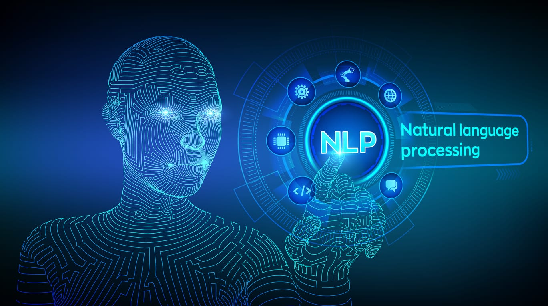

In this notebook we'll learn the foundations of NLP. We'll focus on how language is converted to something a computer can understand.
We'll be building and training a basic character-level Recurrent Neural Network (RNN) to classify words. This tutorial shows how to do preprocess data for NLP modeling “from scratch”, in particular not using many of the convenience functions of torchtext, so you can see how preprocessing for NLP modeling works at a low level.

The model, which will be built with a character-level RNN, reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling

<h2> 2. Importing modules </h2>

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline

torch.manual_seed(0)


<h1> 3. Understanding Data </h1>

Let's take a look at the data we have collected. We'll use the glob module to find the files located in the data/names folder.

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


We keep in a list all the ASCII letters (sorry, letter 'ñ' is not included ...), plus a few punctuation characters.

In [3]:
all_letters = string.ascii_letters + " .,;'"

print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


<strong>Exercise 1</strong>: Set up a variable called n_letters with the total number of characters. This variable will be key in the coming cells.

In [4]:
### Your code starts here ###


### Your code ends here ###

print ("The number of available characters is {0:d}".format(n_letters))

The number of available characters is 57


We now define a function to:
- Normalize (diacritical marks will be decomposed, i.e.: résume --> re´sume)
- Remove non-spacing marks (re´sume --> resume)
- Remove characters not in our all_letters list

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

<strong>Exercise 2</strong>: Apply the function defined above to a name with characters not included in the ASCII list and check out the effects.

In [6]:
### Your code starts here ###

name = 'Muñoz'



### Your code ends here ###

print ("The name {0:s} has been converted to {1:s}".format(name,converted_name))

The name Muñoz has been converted to Munoz


Let's set up a function to read all the names contained in a file and create a list with them

In [7]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

<strong>Exercise 3: Use the function written above to create a list with all the Spanish names included in the data provided.

In [8]:
### Your code starts here ###



# names_list = 

### Your code ends here ###

print("The list with all Spanish names is {0:s}".format(str(names_list)))

The list with all Spanish names is ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua', 'Aquino', 'Araujo', 'Araullo', 'Araya', 'Arce', 'Arechavaleta', 'Arena', 'Aritza', 'Armando', 'Arreola', 'Arriola', 'Asis', 'Asturias', 'Avana', 'Azarola', 'Banderas', 'Barros', 'Basurto', 'Bautista', 'Bello', 'Belmonte', 'Bengochea', 'Benitez', 'Bermudez', 'Blanco', 'Blanxart', 'Bolivar', 'Bonaventura', 'Bosque', 'Bustillo', 'Busto', 'Bustos', 'Cabello', 'Cabrera', 'Campo', 'Campos', 'Capello', 'Cardona', 'Caro', 'Casales', 'Castell', 'Castellano', 'Castillion', 'Castillo', 'Castro', 'Chavarria', 'Chavez', 'Colon', 'Costa', 'Crespo', 'Cruz', 'Cuellar', 'Cuevas', "D'cruz", "D'cruze", 'De la cruz', 'De la fuente', 'Del bosque', 'De leon', 'Delgado', 'Del olmo', 'De santigo', 'Diaz', 'Dominguez', 'D

The following function extracts the name of the file. As you can see, the file name contains the Language associated to the names included in it. This variable will be our Label.
Remember: when we have a discrete number of variables we call it a <strong>categorical variable</strong>

In [9]:
def get_category_from_file(file_url):
    category = os.path.splitext(os.path.basename(file_url))[0]                      
    return category

<strong>Exercise 4: Build a dictionary where the key is the language and the item is the names associated to this language

In [10]:
category_lines = {}

for filename in findFiles('data/names/*.txt'):
    ### Your code starts here
    
    ### Your code ends here


category = 'Dutch'
print("The names associated to category {0:s} are {1:s}".format(category,str(category_lines[category])))

The names associated to category Dutch are ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven', 'Adrichem', 'Aggelen', 'Agteren', 'Agthoven', 'Akkeren', 'Aller', 'Alphen', 'Alst', 'Altena', 'Althuis', 'Amelsvoort', 'Amersvoort', 'Amstel', 'Andel', 'Andringa', 'Ankeren', 'Antwerp', 'Antwerpen', 'Apeldoorn', 'Arendonk', 'Asch', 'Assen', 'Baarle', 'Bokhoven', 'Breda', 'Bueren', 'Buggenum', 'Buiren', 'Buren', 'Can', 'Cann', 'Canne', 'Daal', 'Daalen', 'Dael', 'Daele', 'Dale', 'Dalen', 'Laar', 'Vliert', 'Akker', 'Andel', 'Denend', 'Aart', 'Beek', 'Berg', 'Hout', 'Laar', 'See', 'Stoep', 'Veen', 'Ven', 'Venn', 'Venne', 'Vennen', 'Zee', 'Donk', 'Haanraads', 'Haanraats', 'Haanrade', 'Haanrath', 'Haenraats', 'Haenraets', 'Hanraets', 'Hassel', 'Hautem', 'Hautum', 'Heel', 'Herten', 'Hofwegen', 'Horn', 'Hout', 'Houte', 'Houtem', 'Houten', 'Houttum', 'Houtum', 'Kan', 'Kann', 'Kanne', 'Kappel', 'Karl', 'Kikkert', 'Klein', 'Klerk', 'Klerken', 'Klerks', 'Klerkse', 'Klerkx', 'Klerx', 'Kloet', 'Kloeten

<strong>Exercise 5: Build a list with all categories included in the data. Set up a variable n_categories that contains the total number of categories

In [11]:
### Your code starts here

# all_categories = 
# n_categories = 

### Your code ends here ###

print("There are {0:d} categories included and they are: {1:s}".format(n_categories,str(all_categories)))

There are 18 categories included and they are: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


<h1> 3. From text to Tensor </h1>

We could use the concept of <strong>one-hot vector</strong> to translate a word to something the model can deal with.<br>

A one-hot vector is used to represent a categorical variable, such as a word in a vocabulary. The length of the vector is equal to the size of the vocabulary, and each element in the vector corresponds to a different word in the vocabulary.

In a one-hot vector, all the elements are zero except for one element which has a value of one, indicating the presence of a particular value in the categorical variable.
Next slide shows an example of how a sentence is translated to a bunch of one hot vectors.


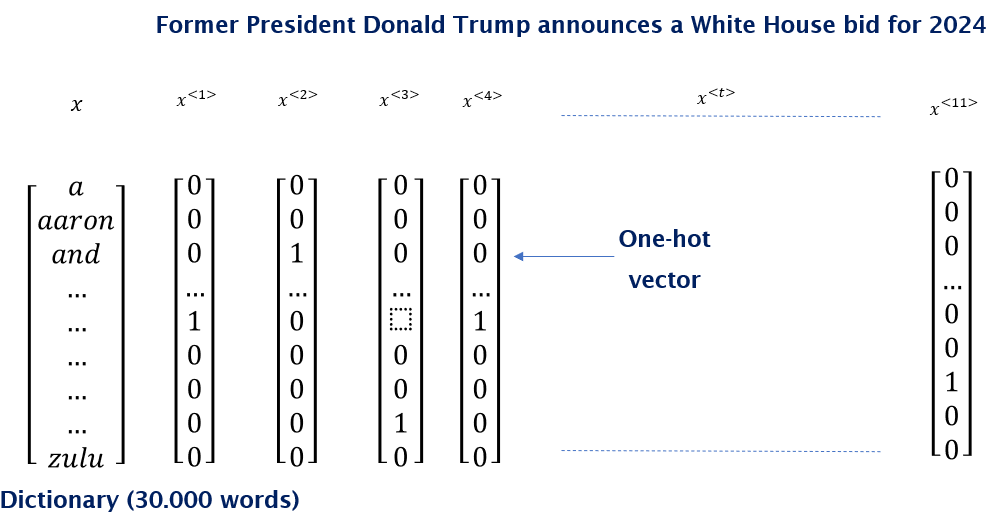

In the example shown above, the length of our dictionary is 30.000 words. Therefore every single vector out of the 11 vectors (words), will have 30000 items with 29999 zeros and only one 1.

Going back to our project, now that we have all the names organized, we need to turn them into Tensors to make any use of them.

We are going to use a “one-hot vector” of size <1 x n_letters> to represent a single letter (instead of a word).<br>
The one-hot vector is filled with 0s except for a 1 at the index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.
That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

<strong>Exercise 6</strong>: Build a function letterToIndex that returns the position of the list of ASCII characters you built in variable all_letters

In [12]:
def letterToIndex(letter):
    
    ### Your code starts here
   
    ### Your code ends here

letter = 'j'

position = letterToIndex(letter)

print("The position of letter {0:s} is {1:d}".format(letter,position))

The position of letter j is 9


<strong>Exercise 7</strong>: Build a function letterToTensor that returns a tensor with all zeros but 1 in the position of the given letter

In [13]:
def letterToTensor(letter):
    ### Your code starts here
    
    ###Your code ends here
    return tensor

letter='h'

one_hot_vector = letterToTensor(letter)

print("The vector associated to {0:s} is {1:s}".format(letter,str(one_hot_vector)))

The vector associated to h is tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


<strong>Exercise 8</strong>: Build a function lineToTensor that returns a (line_length,1,n_letters). In the tensor there will be as many one-hot vectors as letters the name has.

In [14]:
def lineToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    
    ### Your code starts here
    
    ### Your code ends here
    
    return tensor

name = 'Manuel'

tensor = lineToTensor(name)

print("The name {0:s} has a tensor with size {1:s}".format(name,str(tensor.size())))


The name Manuel has a tensor with size torch.Size([6, 1, 57])


<h1>4. Building a Recurrent Neural Network</h1>

A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes can create a cycle, allowing the output from some nodes to affect subsequent inputs to the same nodes. <br>
Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.

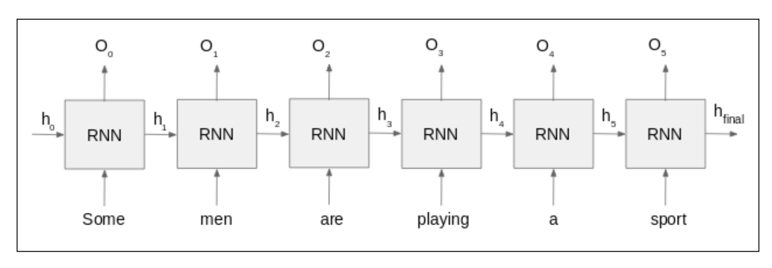

h<sub>0</sub>,...,h<sub>n</sub> stands for the hidden state. The hidden state is the key of RNNs. We can consider the hidden state as the hidden layer in a tradidional DNN, but the hidden state just happens to also be used as an additional input to the RNN at the next time step.

We're going to build the simplest RNN model we can afford (mostly copied from the PyTorch tutorials). It has just 2 linear layers which operate on an input and hidden state, with a Softmax layer after the output.

Let's code this simple RNN as the following diagram shows.

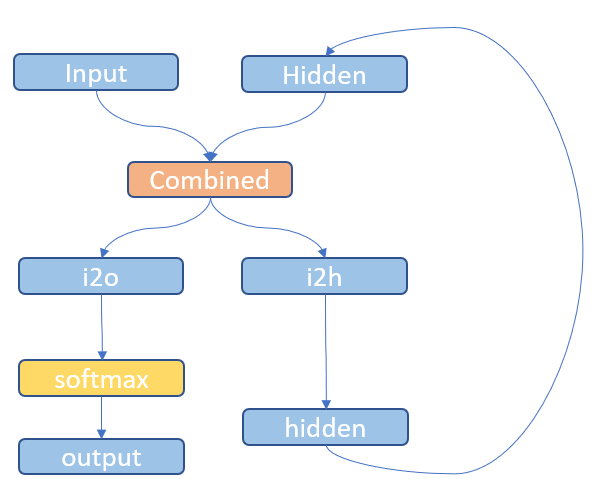

In [60]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

<strong>Exercise 9</strong>: Set up a variable with a name and plug it into the RNN model defined above. Check size of tensors returned by the model. We set up the number of hidden components of the hidden vector.

In [61]:
n_hidden = 128

hidden = torch.zeros(1, n_hidden)

### Your code starts here


### Your code ends here

print("The size of the output tensors are {0:s} and {1:s}".format(str(output.size()),str(next_hidden.size())))

The size of the output tensors are torch.Size([1, 18]) and torch.Size([1, 128])


<strong>Exercise 10</strong>: Show the values of the output and try to figure out what they stand for. Print the sum of all values contained in the output vector

In [62]:
### Your code starts here



### Your code ends here

print("The number of values in the output Tensor is {0:d}".format(n_values_output))
print("The sum of the values in the output tensor is {0:.3f}".format(sum_values))

tensor([[0.0632, 0.0584, 0.0546, 0.0504, 0.0519, 0.0592, 0.0567, 0.0514, 0.0549,
         0.0550, 0.0563, 0.0548, 0.0528, 0.0558, 0.0531, 0.0531, 0.0563, 0.0622]],
       grad_fn=<SoftmaxBackward0>)
The number of values in the output Tensor is 18
The sum of the values in the output tensor is 1.000


Reading through the definition of the model, you'll see that the activation function applied here is Softmax.

Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. <br>
The most common use of the softmax function in applied machine learning is its use as an activation function in a neural network model. <br>
Specifically, the network is configured to output N values, one for each class in the classification task, and the softmax function is used to normalize the outputs, converting them from weighted sum values into probabilities that sum to one. Each value in the output of the softmax function is interpreted as the probability of membership for each class.
In our case, we have 18 categories (Spanish, English, German...); each value of the Tensor will give you the probability of each category for the given name.

Before going into training we should make a few helper functions.
The first is to interpret the output of the network,
which we know to be a likelihood of each category.
We can use Tensor.topk to get the index of the greatest value:

In [63]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 0)


<strong>Exercise 11</strong>: Use the function defined above to figure out the Language predicted by the built model

In [64]:
### Your code starts here ###



### Your code ends here ###

print("The language predicted by the RNN model is {0:s}".format(category_predicted))

The language predicted by the RNN model is Arabic


We will also want a quick way to get a training example (a name and its language). The following function returns a randomly chosen category 

In [65]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

print(randomChoice(all_categories))

Czech


And the following function returns the following data
* The category randomly chosen
* A tensor with the index of the category randomly chosen
* A name that belongs to the category chosen
* A tensor that codifies the name as explained above

In [66]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [67]:
category, line, category_tensor , line_tensor = randomTrainingExample()
print(line)
print(line_tensor.size()[0])

Borovsky
8


<strong>Exercise 12</strong>: Randomly choose 20 names and show their category

In [68]:
### Your code starts here ###


### Your code ends here ###

category = French / line = Sargent
category = Greek / line = Papageorge
category = Spanish / line = Marino
category = German / line = Papp
category = Vietnamese / line = Duong
category = Russian / line = Pohlebkin
category = Chinese / line = Chou
category = Japanese / line = Mizoguchi
category = Irish / line = Mullen
category = Chinese / line = Xuan
category = German / line = Wahner
category = Spanish / line = Alamilla
category = Vietnamese / line = Diep
category = Polish / line = Pokorny
category = German / line = Von essen
category = French / line = Pelletier
category = Russian / line = Novokhatsky
category = Greek / line = Dritsas
category = Scottish / line = Brown
category = Spanish / line = Bautista


<h1>5. Training the Network</h1>

Now all it takes to train this network is to show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

Each loop of training will:
* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in
* Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

<strong>Exercise 13</strong>: Write down the several requested parts of the training function

In [69]:
loss_function = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_rnn(category_tensor, line_tensor):
    
    # Exercise 10.1: Intializer the hidden vector
    ### Your code starts here
    
    ### Your conde ends here
      
    rnn.zero_grad()
    # 1. Forward pass
    # We load the name to the RNN model letter by letter
    for i in range(line_tensor.size()[0]):
        # Exercise 10.2: apply the rnn function to load every letter of the given name
        ### Your code starts here
        
        ### Your code ends here

    # We have chosen a loss function for you. Apply the chosen loss function
    loss = loss_function(output, category_tensor)
    
    # 2. Backward pass
    ### Exercise 10.3: Activate the Pytorch backward pass
    
    ### Your code starts here
   
    ### Your code ends here

    # 3. Optimization function
    # Optimization pass, we code it for you
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples.<br>
The train function returns both the output and loss, so we can print its guesses and also keep track of loss for plotting.<br>
Since there are 1000s of examples we print only every print_every examples,
and take an average of the loss.

In [70]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

We define some useful parameters for the training stage

In [71]:
n_epochs = 30000
print_every = 5000
plot_every = 1000

<strong>Exercise 14</strong>: Use the training function to train the model (multiple exercise)

5000 16% -0.0526 Allman / Chinese ✗ (English)
10000 33% -0.0550 Campos / French ✗ (Portuguese)
15000 50% -0.0603 an / Chinese ✗ (Vietnamese)
20000 66% -0.0606 Filipek / French ✗ (Polish)
25000 83% -0.0534 Dang / Chinese ✗ (Vietnamese)
30000 100% -0.0554 Ullmann / Dutch ✗ (English)


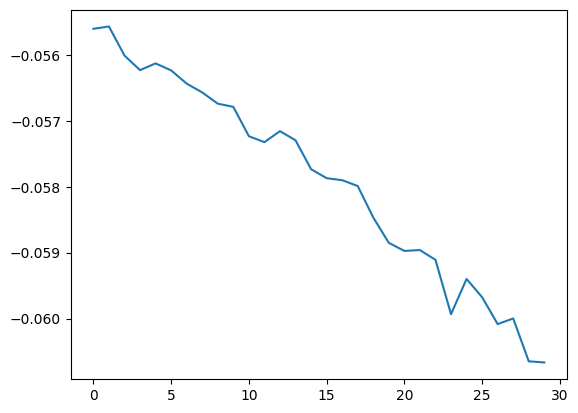

In [72]:
for epoch in range(1, n_epochs + 1):
    
    # Exercise 11.1: Generate the category, line, category_tensor and line_tensor randomly
    
    ### Your code starts here ###
    # category, line, category_tensor, line_tensor = 
    ### Your code ends here ###
    
    # Exercise 11.2: Call the train the function
    ### Your code starts here ###
    # output, loss = 
    ### Your code ends here ###
    
    current_loss += loss

    # Print iter number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


plt.figure()
plt.plot(all_losses)

The losses shown above are telling as that the model is learning properly, let's evaluate the model

<h1> 5. Evaluating the network </h1>

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). <br>
To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

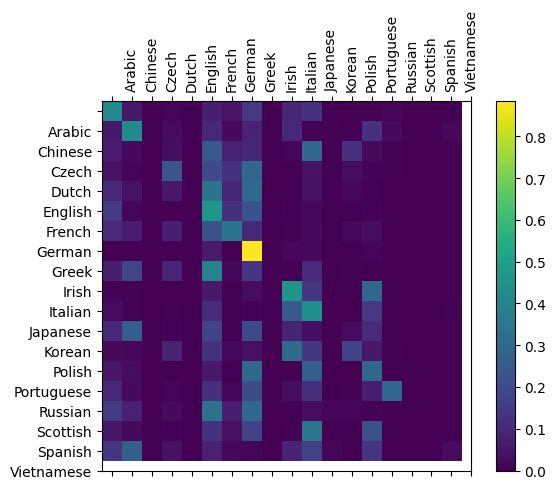

In [73]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_rnn(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticks(range(len(all_categories)+1))
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticks(range(len(all_categories)+1))
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Something is not working well in the model. Confussion matrix tells us that, after evaluating 10000 names, only certain names seem to be detected properly. We have coded a function that can be used by you to check your own names.

In [74]:
def predict_rnn(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_rnn(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [75]:
predict_rnn('Pelaez')
predict_rnn('Witek')
predict_rnn('Nienhuis')



> Pelaez
(0.06) Arabic
(0.06) French
(0.06) Dutch

> Witek
(0.06) French
(0.06) Dutch
(0.06) Polish

> Nienhuis
(0.09) Greek
(0.06) French
(0.06) Portuguese


<strong>Exercise 15</strong>: Come up with a fix that solves the performance of the model. Apply your fix and check out if it works.<br>
    Good luck!

In [ ]:
# LogSoftmax instead of Softmax
